In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
!pip install -U scikit-learn

In [3]:
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2025-11-12 16:47:24--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2025-11-12 16:47:25 (26.7 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [5]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [6]:
df['LogPassengers'] = np.log(df['Passengers'])

In [7]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [8]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [9]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [55]:
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [56]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [57]:
# Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [58]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [59]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=150,
  validation_data=(Xtest, Ytest)
)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0134 - val_loss: 0.0113
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0115 - val_loss: 0.0102
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0101 - val_loss: 0.0093
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0073 - val_loss: 0.0076
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0056 - val_loss: 0.0064
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0052 - val_loss: 0.0061
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0048 - val_loss: 0.0057
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0045 - val_lo

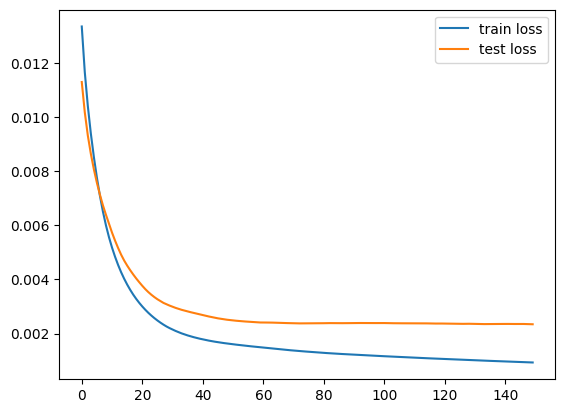

In [60]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [64]:
train_idx[:T+1] = False # first T+1 values are not predictable because first entry is NAN and next T are independent variables for prediction of T+2 th entry

In [65]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [66]:
# Store diff predictions
df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

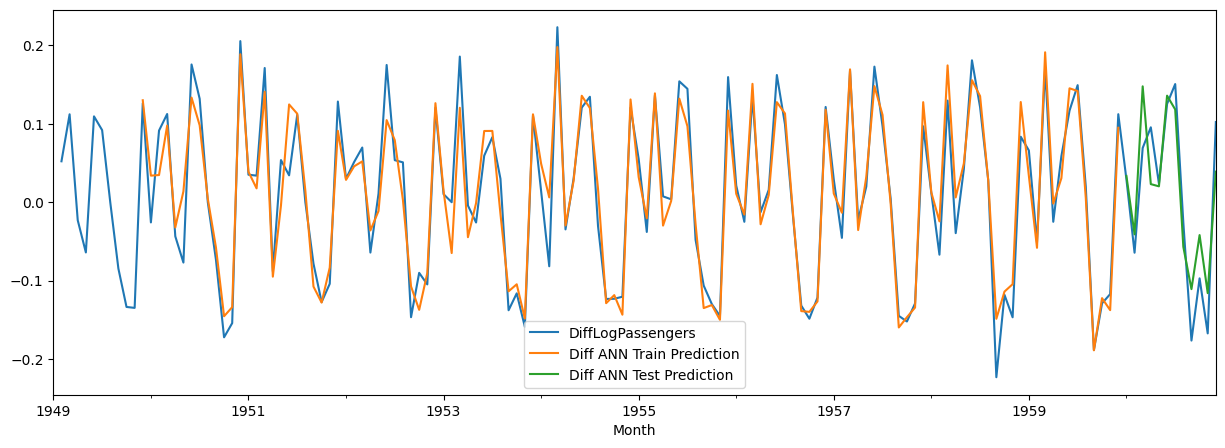

In [67]:
cols = ['DiffLogPassengers',
        'Diff ANN Train Prediction',
        'Diff ANN Test Prediction']
df[cols].plot(figsize=(15, 5));

In [68]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [69]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [70]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

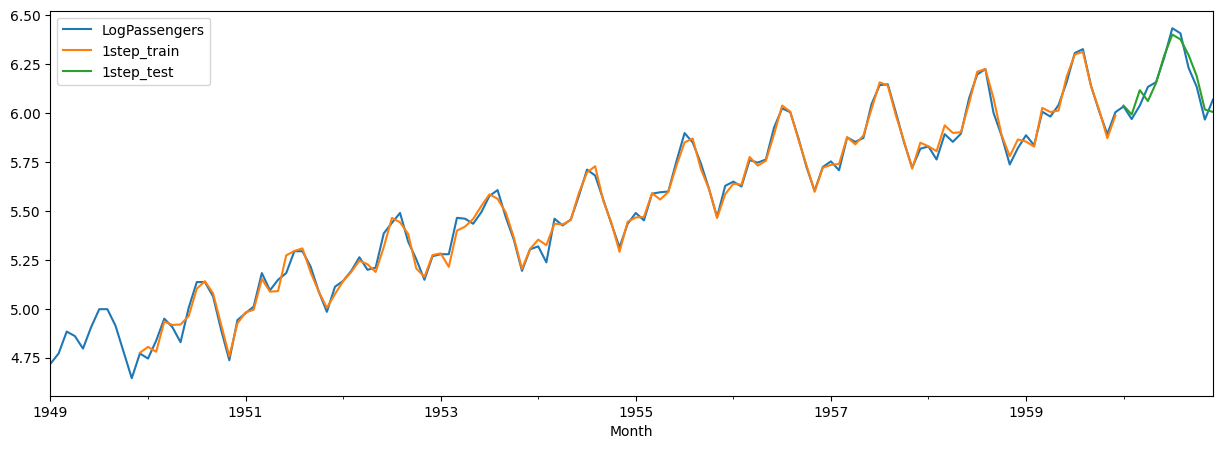

In [71]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [72]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

/tmp/ipython-input-692323302.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_x[-1] = p


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [73]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

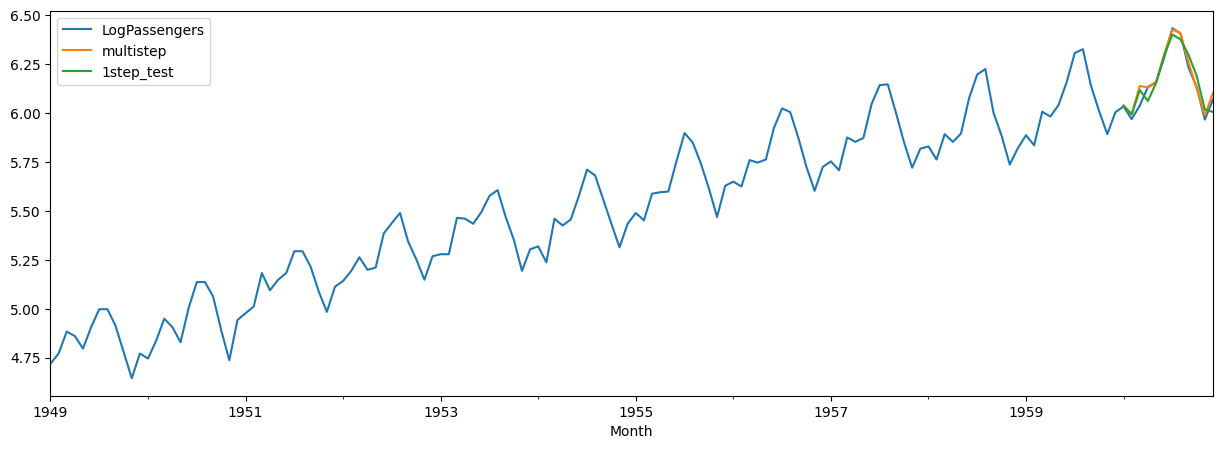

In [74]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [75]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [76]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [77]:
# Basic ANN
i = Input(shape=(Tx,))
x = Dense(32, activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i, x)

In [78]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [79]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=150,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0150 - val_loss: 0.0153
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0140 - val_loss: 0.0146
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0132 - val_loss: 0.0140
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0125 - val_loss: 0.0134
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0119 - val_loss: 0.0130
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0114 - val_loss: 0.0125
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0110 - val_loss: 0.0120
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0106 - val_loss: 0.0116
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0102 - val_loss: 0.0112
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0099 - val_loss: 0.0108
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0096 - val_loss: 0.0104
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0093 - val_lo

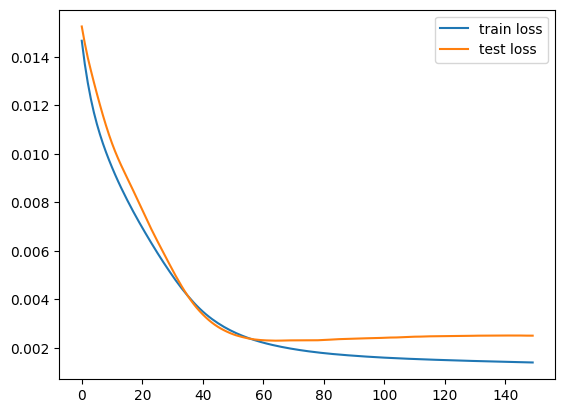

In [80]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [84]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [85]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [86]:
# in Ptrain each row is prediction for next 12 days. But we choose only 0th column because it is next day prediction out of next 12 days
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [87]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

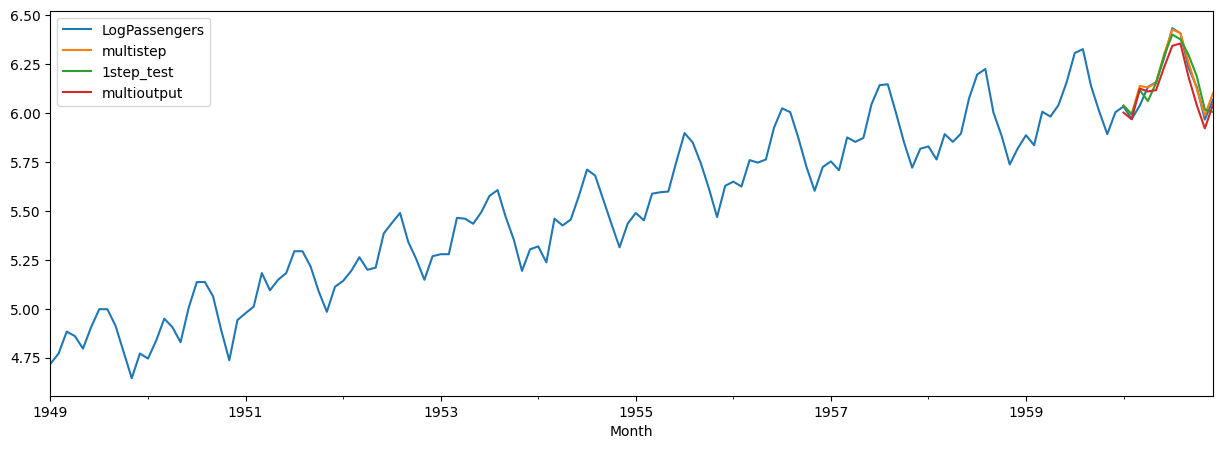

In [88]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [89]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.003469608882649845
multi-output MAPE: 0.007851165526798522


In [78]:
# Exercise:
# Do you think differencing is unnecessary? Try it!
# Do you think logging is unnecessary? Try it!
# Do you think including more past lags would be useful?
# Have you considered walk-forward validation to optimize hyperparameters?